In [4]:
%pip install tensorboard
%pip install stable-baselines3
%pip install gymnasium
%pip install shimmy
%pip install torch
%pip install stable-baselines3 gym

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt

In [6]:
def generador_data(fac, dem, deman_max):
    ancho = 2500
    cor_dem = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(dem)]
    dem_p = [random.randint(1, deman_max) for _ in range(dem)]  # Tamaño de puntos escalado para visualización

    cor_fac = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(fac)]

    # Crear el grafo
    G = nx.Graph()

    # Añadir nodos de demanda y facilidad al grafo
    for i, coord in enumerate(cor_dem):
        G.add_node(f"D{i}", pos=coord, demand=dem_p[i], color='red', size=dem_p[i])

    for j, coord in enumerate(cor_fac):
        G.add_node(f"F{j}", pos=coord, color='blue', size=100)  # Tamaño fijo para facilidades

    # Conectar nodos si cumplen una condición específica (e.g., todos conectados)
    cover=[]
    for i, c_dem in enumerate(cor_dem):
        for j, c_fac in enumerate(cor_fac):
            # Conectar si la distancia es menor a un umbral, ajustar según necesidad
            if sqrt((c_dem[0] - c_fac[0]) ** 2 + (c_dem[1] - c_fac[1]) ** 2) < 500:
                cover.append(1)
                G.add_edge(f"D{i}", f"F{j}")
            else:
                cover.append(0)

    cover=m_cover=pd.DataFrame(np.array(cover).reshape(fac,dem))
    # Establecer el tamaño de la figura (ancho x alto en pulgadas)
    plt.figure(figsize=(15, 15))  # Ajuste del tamaño de la figura a 15x15 pulgadas
    pos = nx.get_node_attributes(G, 'pos')
    colors = [G.nodes[node]['color'] for node in G.nodes]
    sizes = [G.nodes[node]['size'] for node in G.nodes]

    nx.draw(G, pos, node_color=colors, node_size=sizes, with_labels=False, edge_color='gray', alpha=0.6)
    plt.title('Red de Puntos de Demanda y Facilidades')
    plt.show()
    return dem_p,cover


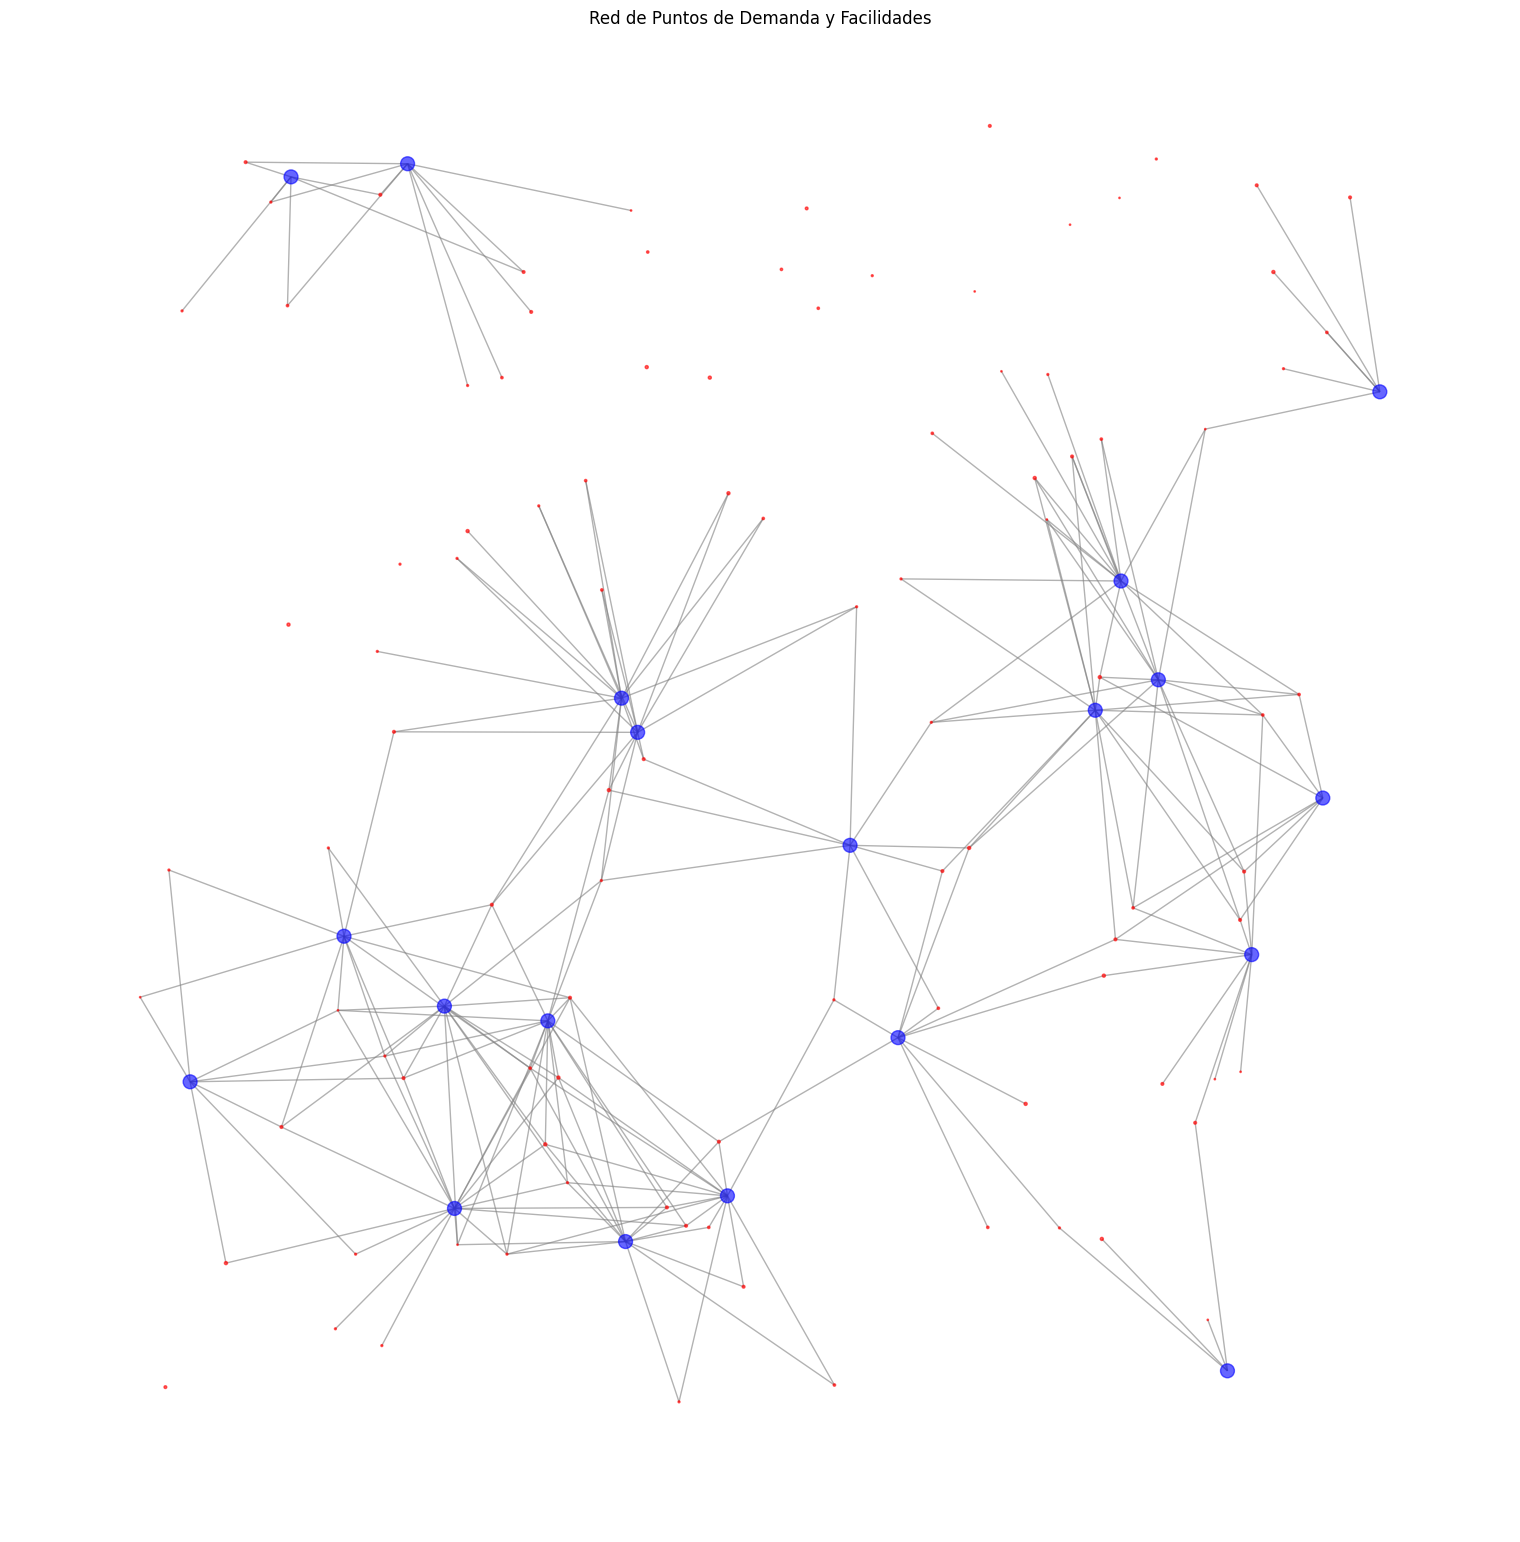

6120


In [7]:
fac=20
demp=100
deman_max=5
demanda,m_cover=generador_data(fac, demp, deman_max)
print(demanda)

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim

class HumanitarianFacilityLocationEnv(gym.Env):
    """Entorno para modelar la ubicación de facilidades en situaciones humanitarias."""
    def __init__(self, num_people, num_facilities, num_days, coverage_matrix, max_installations_per_facility=5, max_capacity_per_facility=500, max_total_installations=100):
        super(HumanitarianFacilityLocationEnv, self).__init__()
        self.num_people = num_people
        self.num_facilities = num_facilities
        self.num_days = num_days
        self.current_day = 0
        self.coverage_matrix = np.array(coverage_matrix, dtype=np.int32)
        self.demand_status = np.ones(self.num_people, dtype=int)
        self.max_installations_per_facility = max_installations_per_facility
        self.max_capacity_per_facility = max_capacity_per_facility
        self.max_total_installations = max_total_installations
        self.installations_per_facility = np.zeros(num_facilities, dtype=int)
        self.available_installations = max_total_installations
        self.action_space = spaces.MultiDiscrete([num_facilities, 4])  # Actions: Install, Move, Remove
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_people,), dtype=np.uint8)

    def reset(self):
        self.current_day = 0
        self.installations_per_facility.fill(0)
        self.available_installations = self.max_total_installations
        self.demand_status.fill(1)  # Reset demand status to not covered
        self.state = self.update_coverage()
        return self.state

    def update_coverage(self):
        installations_2d = self.installations_per_facility.reshape(-1, 1)
        coverage_matrix_t = self.coverage_matrix.T
        total_coverage = np.dot(coverage_matrix_t, installations_2d).squeeze()
        self.state = np.where(total_coverage >= 1, 0, self.demand_status)
        return self.state

    def step(self, action):
        facility_index, action_type = action
        if action_type == 0 and self.available_installations > 0 and self.installations_per_facility[facility_index] < self.max_installations_per_facility:
            self.installations_per_facility[facility_index] += 1
            self.available_installations -= 1
        elif action_type == 1 and self.installations_per_facility[facility_index] > 0:
            destination_index = random.choice([i for i in range(self.num_facilities) if i != facility_index and self.installations_per_facility[i] < self.max_installations_per_facility])
            self.installations_per_facility[facility_index] -= 1
            self.installations_per_facility[destination_index] += 1
        elif action_type == 2 and self.installations_per_facility[facility_index] > 0:
            self.installations_per_facility[facility_index] -= 1
            self.available_installations += 1
        reward = self.evaluate_reward()
        self.state = self.update_coverage()
        self.current_day += 1
        done = self.current_day >= self.num_days or np.all(self.state == 0)
        info = {}
        return self.state, reward, done, info

    def evaluate_reward(self):
        # Reward for reducing the number of uncovered demands
        uncovered = np.sum(self.state)
        return -uncovered

class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNetwork, self).__init__()
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=0.1):
        self.model = DQNNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.epsilon = epsilon

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def update_model(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        action = torch.LongTensor([action])
        reward = torch.FloatTensor([reward])
        done = torch.FloatTensor([done])

        current_q = self.model(state).gather(1, action.unsqueeze(1))
        max_next_q = self.model(next_state).max(1)[0].detach()  # Obtener el Q máximo del siguiente estado
        expected_q = reward + 0.99 * max_next_q * (1 - done)  # Calcular el Q objetivo

        loss = self.criterion(current_q, expected_q.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



# Main execution
num_people = demanda
num_facilities = fac
num_days = 10
coverage_matrix = m_cover

env = HumanitarianFacilityLocationEnv(num_people=num_people,
                                      num_facilities=num_facilities,
                                      num_days=num_days,
                                      coverage_matrix=coverage_matrix)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.nvec.prod()
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)

num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        agent.update_model(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")


In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim

class HumanitarianFacilityLocationEnv(gym.Env):
    """Entorno para modelar la ubicación de facilidades en situaciones humanitarias."""
    def __init__(self, num_demand_points, num_facilities, num_days, coverage_matrix, people_per_demand_point, 
                 max_installations_per_facility=5, max_capacity_per_facility=500, max_total_installations=100):
        super(HumanitarianFacilityLocationEnv, self).__init__()
        self.num_demand_points = num_demand_points
        self.num_facilities = num_facilities
        self.num_days = num_days
        self.current_day = 0
        self.coverage_matrix = np.array(coverage_matrix, dtype=np.int32)
        self.people_per_demand_point = np.array(people_per_demand_point, dtype=np.int32)
        self.demand_status = np.ones(self.num_demand_points, dtype=int)  # 1 = sin cubrir, 0 = cubierta
        self.max_installations_per_facility = max_installations_per_facility
        self.max_capacity_per_facility = max_capacity_per_facility
        self.max_total_installations = max_total_installations
        self.installations_per_facility = np.zeros(num_facilities, dtype=int)
        self.available_installations = max_total_installations
        self.action_space = spaces.MultiDiscrete([num_facilities, 4])  # Acciones: Install, Move, Remove
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_demand_points,), dtype=np.uint8)

    def reset(self):
        self.current_day = 0
        self.installations_per_facility.fill(0)
        self.available_installations = self.max_total_installations
        self.demand_status.fill(1)  # Restablecer el estado de la demanda a no cubierta
        self.state = self.update_coverage()
        return self.state

    def update_coverage(self):
        installations_2d = self.installations_per_facility.reshape(-1, 1)
        coverage_matrix_t = self.coverage_matrix.T
        total_coverage = np.dot(coverage_matrix_t, installations_2d).squeeze()
        self.state = np.where(total_coverage >= 1, 0, self.demand_status)
        return self.state

    def step(self, action):
        facility_index, action_type = action
        if action_type == 0 and self.available_installations > 0 and self.installations_per_facility[facility_index] < self.max_installations_per_facility:
            self.installations_per_facility[facility_index] += 1
            self.available_installations -= 1
        elif action_type == 1 and self.installations_per_facility[facility_index] > 0:
            destination_index = random.choice([i for i in range(self.num_facilities) if i != facility_index and self.installations_per_facility[i] < self.max_installations_per_facility])
            self.installations_per_facility[facility_index] -= 1
            self.installations_per_facility[destination_index] += 1
        elif action_type == 2 and self.installations_per_facility[facility_index] > 0:
            self.installations_per_facility[facility_index] -= 1
            self.available_installations += 1
        reward = self.evaluate_reward()
        self.state = self.update_coverage()
        self.current_day += 1
        done = self.current_day >= self.num_days or np.all(self.state == 0)
        info = {}
        return self.state, reward, done, info

    def evaluate_reward(self):
        # Reward for reducing the number of uncovered demands
        uncovered_people = np.sum(self.state * self.people_per_demand_point)
        return -uncovered_people 


class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNNetwork, self).__init__()
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=0.1):
        self.model = DQNNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.epsilon = epsilon

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def update_model(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        action = torch.LongTensor([action])
        reward = torch.FloatTensor([reward])
        done = torch.FloatTensor([done])

        current_q = self.model(state).gather(1, action.unsqueeze(1))
        max_next_q = self.model(next_state).max(1)[0].detach()  # Obtener el Q máximo del siguiente estado
        expected_q = reward + 0.99 * max_next_q * (1 - done)  # Calcular el Q objetivo

        loss = self.criterion(current_q, expected_q.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



# Main execution
num_demand_points = demp#  Cantidad de puntos de demanda
num_facilities = fac# Cantidad de instalaciones 
num_days = 5
coverage_matrix = m_cover# Matriz de cobertura (definida como antes)
people_per_demand_point = # demandaVector con el número de personas por punto de demanda

env = HumanitarianFacilityLocationEnv(num_demand_points=num_demand_points,
                                      num_facilities=num_facilities,
                                      num_days=num_days,
                                      coverage_matrix=coverage_matrix,
                                      people_per_demand_point=people_per_demand_point)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.nvec.prod()
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)

num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        agent.update_model(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
